## TensorFlow Tutorial Lab-MNIST

### License (MIT) Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

sklearn import 하기위해, pip install sklearn 설치

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

버전 확인 하기 

In [2]:
tf.__version__

'0.12.1'

## Load Data
MNIST 데이터는 12MB이고, 다운바기 혹은 읽어들이기 방법.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set has now been loaded and consists of 70.000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


validation 셋은 training 셋의 결과를 Overfitting Or Underfitting을 검증함

### One-Hot Encoding

처음 5개의 이미지를 One-Hot 인코딩예시를 보여줌

In [5]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

One-hot 인코딩을 숫자로 변환하여 0~9사이 숫자를 갖는 class로 만듬 

In [6]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [7]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4], dtype=int64)

### Data dimensions

In [8]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

3x3 이미지 9개를 그리는 정의 

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

### Plot a few images to see if data is correct

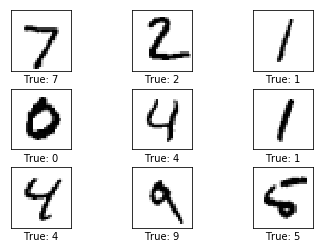

In [10]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Placeholder variables

In [11]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

None은 나중에 batch 작업시 결정하면 되고, 
img_size_flat은 이 예제의 경우는 10임

In [12]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [13]:
y_true_cls = tf.placeholder(tf.int64, [None])

### Variables to be optimized

In [14]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [15]:
biases = tf.Variable(tf.zeros([num_classes]))

### Model

In [16]:
logits = tf.matmul(x, weights) + biases

In [17]:
y_pred = tf.nn.softmax(logits)

In [18]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

### Cost-function to be optimized

In [19]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_true)

In [20]:
cost = tf.reduce_mean(cross_entropy)

### Optimization method

In [21]:
learning_rate=0.5
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

### Performance measures

In [22]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [23]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

In [24]:
session = tf.Session()

In [25]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

50,000개 이미지가 Training 셋이고, 계산시간이 오래걸리기 때문에 작은 batch를 이용한 Stochastic Gradient Descent (SGD) 방법을 사용함. 참고로 batch_size=50,000이면 모든 것을 한번에 다 계산하는 것과 같음

In [26]:
batch_size = 100

In [27]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
 
        session.run(optimizer, feed_dict=feed_dict_train)

### Helper-functions to show performance

테스트에 대한 feed_dict_test를 설정함

In [28]:
feed_dict_test = {x: data.test.images, y_true: data.test.labels,  y_true_cls: data.test.cls}

In [29]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)

    print("Accuracy on test-set: {0:.4%}".format(acc))

In [30]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

Function for plotting examples of images from the test-set that have been mis-classified.

In [31]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot the model weights

In [32]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

## Performance before any optimization

테스트셋의 정확도은 최기화 모델값으로 사용한 것으로, 모델 최적화가 적용이 아직 안되었다. 



In [33]:
print_accuracy()

Accuracy on test-set: 9.8000%


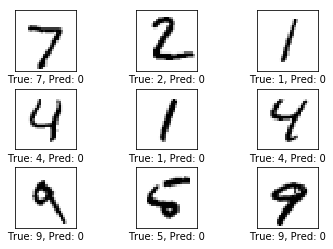

In [34]:
plot_example_errors()

최적화를 1번 했을 경우 

In [35]:
optimize(num_iterations=1)

In [36]:
print_accuracy()

Accuracy on test-set: 40.7500%


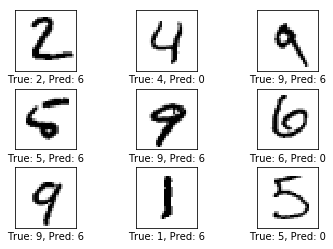

In [37]:
plot_example_errors()

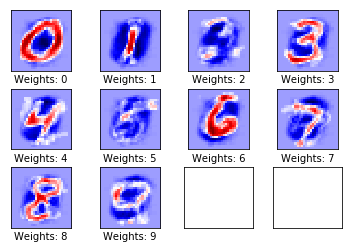

In [38]:
plot_weights()

최적화를 10번 했을 경우

In [39]:
# We have already performed 1 iteration.
optimize(num_iterations=9)

In [40]:
print_accuracy()

Accuracy on test-set: 78.2100%


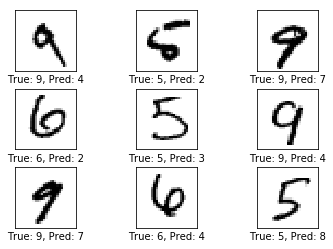

In [41]:
plot_example_errors()

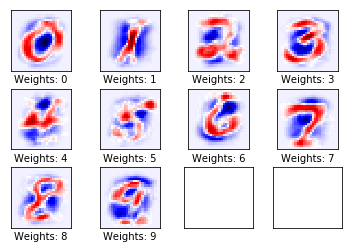

In [42]:
plot_weights()

최적화를 1000번 할 경우

In [43]:
# We have already performed 10 iterations.
optimize(num_iterations=1000)

In [44]:
print_accuracy()

Accuracy on test-set: 91.7800%


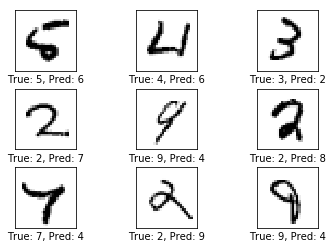

In [45]:
plot_example_errors()

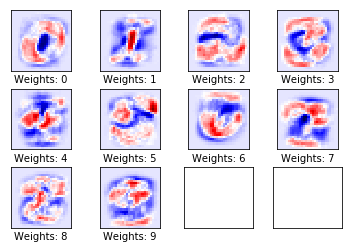

In [46]:
plot_weights()

Confusion Matrix 사용 결과 

[[ 957    0    1    2    0    6   11    1    2    0]
 [   0 1113    2    2    1    1    4    2   10    0]
 [  10   11  888   19   16    2   16   16   44   10]
 [   3    1   12  911    1   33    3   14   22   10]
 [   1    2    2    1  926    0   12    2    7   29]
 [  11    5    1   36   11  764   18    8   31    7]
 [  11    3    3    2   11   11  915    1    1    0]
 [   3   13   17    8    8    1    0  948    2   28]
 [   6   13    5   17    9   25   11   13  869    6]
 [  10    8    1    7   58    6    1   21   10  887]]


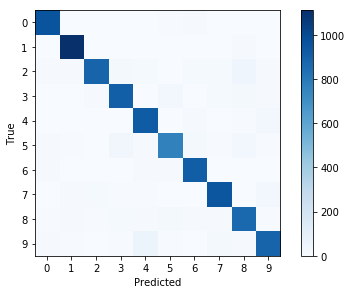

In [47]:
print_confusion_matrix()

We are now done using TensorFlow, so we close the session to release its resources.

In [48]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.